In [1]:
import math
import numpy as np
import pandas as pd
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Calibration
## Preparation of input data
Synthesise travel cost and accessibility columns from the calibration dataset

In [2]:
input_path = '../input/transport_demand/'
model_path = '../model/'

In [3]:
# Load StepModel with LOS table...
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
los = stepmodel.read_json(model_path + 'de_pt_los')

In [4]:
sm.pt_los = los.pt_los

In [5]:
trips = pd.read_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')
print(trips.shape)

(102097, 31)


In [6]:
trips = trips.drop(columns='Unnamed: 0')
trips.reset_index(drop=True, inplace=True)
#trips.head()

### What are calibration data requirements?
The mathematical formulation of the discrete choice model defines the requirements:
> V = T • β_t + β_cost • C • SU + β_access • AC

Note: All parameters are demand group specific. The model formulation for each mode is the same, even though some variables are zero.

## Travel cost
For model calibration with above formula, we need cost data for each trip. This column is generated using the travel cost function from the model's LoS formulation. For PT, the type of ticket or subscription is being considered.

In [7]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [8]:
trips['cost_walk'] = 0 # foot and bicycle trips are free of monetary cost

In [9]:
# The same assumptions for car travel as in the car LoS generation (prep30)
vc_car = 0.00011439257425742574 # in €/m
fix_car = 1.551890814081408 # in € per trip

In [10]:
# Car, see prep30_los_road
trips['cost_car'] = [monetary_cost(d*1000, 1, vc_car, 0,0,0,0, n) + 0.8 * t/60
                     for d, n, t in zip(trips['distance'], trips['n_persons'], trips['duration'])]

In [11]:
# Ticket type determines the trip cost
# Assume this dict with factors
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}

In [12]:
# Rail short-distance
# Trips with subscriptions are free of charge
rf_rail = 0.7 # for distance in km; see prep31
trips['cost_rail_short_distance'] = [monetary_cost(d, rf_rail, 1, 0,0,0,0, 1)
                                     * ticket_dict[t]
                                     for d, t in zip(trips['distance'],
                                                     trips['ticket_type'])]

In [13]:
# Rail long-distance
# Take prices from the model (validated)
rail_dict = sm.pt_los.sort_values(['time', 'length']).loc[
    sm.pt_los['route_type'].isin(
        ['rail_long_distance', 'rail_short_distance'])].groupby(
    ['origin', 'destination']).first()['price'].to_dict()
trips['cost_rail_long_distance'] = [rail_dict[(o,d)]
                                    if (o,d) in rail_dict.keys()
                                    else np.inf
                                    for o, d in zip(trips['origin'], trips['destination'])]

In [14]:
# Bus and tram
# Trip cost depend on the ticket type and routed distance
# The single ticket price is for long distance local transport
# See prep31 for prices
trips['cost_bus'] = trips['ticket_type'].map(ticket_dict) * 2.74

In [15]:
# Coach
# see prep31
trips['cost_coach'] = trips['distance'].apply(
    lambda d: monetary_cost(d, 1, 0.107, 0, 0, 0, 0, 1))

In [16]:
# Air
# Apply business price of German flight connections, see prep31
# Take the fastest connections from the model
air_dict = sm.pt_los.sort_values('time').loc[
    sm.pt_los['route_type']=='air'].groupby(
    ['origin', 'destination']).first()['price'].to_dict()

In [17]:
trips['cost_air'] = [air_dict[(o,d)] if (o,d) in air_dict.keys() else np.inf
                     for o, d in zip(trips['origin'], trips['destination'])]

In [18]:
# The fastest route determines cost of rail service
trips['cost_rail'] = [c_l if t_l<t_s else c_s
                      for t_s, t_l, c_s, c_l in zip(
    trips['time_rail_short_distance'], trips['time_rail_long_distance'],
    trips['cost_rail_short_distance'], trips['cost_rail_long_distance'])]
trips.loc[trips['mode_model']==1, 'cost_rail'] = \
    trips.loc[trips['mode_model']==1, 'cost_rail_short_distance']
trips.loc[trips['mode_model']==2, 'cost_rail'] = \
    trips.loc[trips['mode_model']==2, 'cost_rail_long_distance']

In [19]:
# Summary
trips.groupby('mode_model').agg({'cost_car': 'mean', 'cost_coach': 'mean',
                                 'cost_bus': 'mean', 'cost_air': 'mean',
                                 'cost_rail_short_distance': 'mean',
                                 'cost_rail_long_distance': 'mean',
                                 'cost_rail': 'mean'})

,cost_car,cost_coach,cost_bus,cost_air,cost_rail_short_distance,cost_rail_long_distance,cost_rail
mode_model,,,,,,,
1,3.753492,3.290798,1.272008,inf,4.926426,inf,4.926426
2,19.523105,21.506749,1.777330,inf,26.159033,inf,inf
3,7.229984,10.818476,1.807258,inf,16.927897,inf,29.623916
4,1.814277,1.485729,1.533932,inf,3.345878,inf,13.831564
5,38.094602,53.268468,2.192000,inf,58.848923,inf,83.890451
6,3.169028,3.692293,2.511808,inf,9.638254,inf,16.725208
7,0.701736,0.454862,2.210042,inf,1.879464,inf,25.814157


In [20]:
# Summary
trips.replace({np.inf:np.nan}).groupby('mode_model').agg(
    {'cost_car': 'mean', 'cost_coach': 'mean',
     'cost_bus': 'mean', 'cost_air': 'mean',
     'cost_rail_short_distance': 'mean',
     'cost_rail_long_distance': 'mean',
     'cost_rail': 'mean'})

,cost_car,cost_coach,cost_bus,cost_air,cost_rail_short_distance,cost_rail_long_distance,cost_rail
mode_model,,,,,,,
1,3.753492,3.290798,1.272008,151.857261,4.926426,26.292869,4.926426
2,19.523105,21.506749,1.777330,144.441817,26.159033,65.370906,65.370906
3,7.229984,10.818476,1.807258,165.048440,16.927897,49.022139,29.623916
4,1.814277,1.485729,1.533932,148.933097,3.345878,41.458870,13.831564
5,38.094602,53.268468,2.192000,93.846845,58.848923,92.738633,83.890451
6,3.169028,3.692293,2.511808,158.753144,9.638254,37.813549,16.725208
7,0.701736,0.454862,2.210042,164.302278,1.879464,57.363530,25.814157


In [21]:
sm.pt_route_types

['rail_long_distance', 'rail_short_distance', 'coach', 'air', 'bus']

In [22]:
# How many observations must be dropped later and what are their shares?
mode_dict = {1: 'rail_short_distance', 2: 'rail_long_distance',
             3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_dict = {v:k for k,v in mode_dict.items()}
for t in mode_dict.keys():
    k = len(trips.loc[((trips['mode_model']==mode_dict[t]) & (trips['cost_'+t]==np.inf))])
    print('{}: {} observations have no model connection ({} percent)'.format(
        t, k, k/len(trips.loc[trips['mode_model']==mode_dict[t]])*100))

rail_short_distance: 0 observations have no model connection (0.0 percent)
rail_long_distance: 33 observations have no model connection (3.6830357142857144 percent)
coach: 0 observations have no model connection (0.0 percent)
bus: 0 observations have no model connection (0.0 percent)
air: 4 observations have no model connection (15.384615384615385 percent)
car: 0 observations have no model connection (0.0 percent)
walk: 0 observations have no model connection (0.0 percent)


Dropping a few percent of rail observations will skew the calibration towards the car. Thus, the same share of car, bus, coach trips from the same distance categories should be dropped as well. Air transport has so few observations that correct calibration of air trips is not possible with dataset anyways.

<AxesSubplot:xlabel='purpose_vp'>

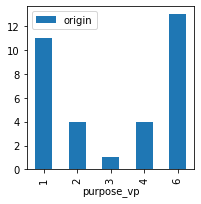

In [23]:
# Purpose distribution of trips that will be dropped
trips.loc[((trips['mode_model']==2) & (trips['cost_rail_long_distance']==np.inf))
         ].groupby('purpose_vp').agg({'origin': 'count'}).plot.bar(figsize=(3,3))

## Accessibility
Another important variable for the mode choice model is the accessibility of transport modes. Cars are highly accessible (1), only if there is one available. We apply the formula from the model. 
It considers the distance to the next train/bus stop from the start and end position.

In [24]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) inverse weight of distances
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [25]:
# The maximum accessibility for foot, bicycle and car is 1
trips['accessibility_walk'] = 1
trips['accessibility_car'] = trips['car_avail'].replace({9:0})

In [26]:
# Rail
# People don't differentiate between long and short distance accessibility
# if there is at least one railway station nearby
trips['accessibility_rail'] = [accessibility(o, d) for o, d in zip(
    trips['dist_train_origin'], trips['dist_train_destination'])]

In [27]:
# Bus
trips['accessibility_bus'] = [accessibility(o, d) for o, d in zip(
    trips['dist_bus_origin'], trips['dist_bus_destination'])]

In [28]:
# Coach
# Assume: It has the same accessibility as rail
trips['accessibility_coach'] = trips['accessibility_rail']

In [29]:
# Air
# Take the model's accessibility from the shortest path
air_dict = sm.pt_los.sort_values('length').loc[
    sm.pt_los['route_type']=='air'].groupby(
    ['origin', 'destination']).first()['accessibility'].to_dict()

In [30]:
trips['accessibility_air'] = [air_dict[(o,d)]
                              if (o,d) in air_dict.keys() else 0
                              for o, d in zip(trips['origin'], trips['destination'])]

In [31]:
# Summary
trips.groupby('mode_model').agg(
    {'accessibility_car': 'mean', 'accessibility_rail': 'mean',
     'accessibility_coach': 'mean', 'accessibility_bus': 'mean',
     'accessibility_air': 'mean'})

,accessibility_car,accessibility_rail,accessibility_coach,accessibility_bus,accessibility_air
mode_model,,,,,
1,0.812479,0.721511,0.721511,0.764089,0.003079
2,0.746652,0.707980,0.707980,0.773884,0.053695
3,0.829167,0.547292,0.547292,0.631458,0.021785
4,0.833294,0.601636,0.601636,0.721271,0.012477
5,0.961538,0.173077,0.173077,0.259615,0.137898
6,0.987120,0.624525,0.624525,0.741169,0.005781
7,0.893798,0.326508,0.326508,0.380331,0.021304


In [32]:
trips[['accessibility_car', 'accessibility_rail', 'accessibility_coach',
       'accessibility_bus', 'accessibility_air']].mean()

accessibility_car      0.965709
accessibility_rail     0.622929
accessibility_coach    0.622929
accessibility_bus      0.733301
accessibility_air      0.006746
dtype: float64

In [33]:
# How many observations have zero accessibility even though they were chosen?
mode_dict = {1: 'rail', 2: 'rail',
             3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_dict = {v:k for k,v in mode_dict.items()}
for t in mode_dict.keys():
    k = len(trips.loc[((trips['mode_model']==mode_dict[t]) & (trips['accessibility_'+t]==0))])
    print('{}: {} observations have zero accessibility ({} percent)'.format(
        t, k, k/len(trips.loc[trips['mode_model']==mode_dict[t]])*100))

rail: 112 observations have zero accessibility (12.5 percent)
coach: 62 observations have zero accessibility (25.833333333333336 percent)
bus: 727 observations have zero accessibility (17.23974389376334 percent)
air: 12 observations have zero accessibility (46.15384615384615 percent)
car: 1137 observations have zero accessibility (1.2880349819879013 percent)
walk: 0 observations have zero accessibility (0.0 percent)


In [34]:
trips.loc[trips.isna().any(axis=1)]

,origin,destination,SKTYP,distance,distance_routed,duration,purpose,mode,mode_combo,n_persons,...,cost_bus,cost_coach,cost_air,cost_rail,accessibility_walk,accessibility_car,accessibility_rail,accessibility_bus,accessibility_coach,accessibility_air


## Save dataset

In [35]:
trips.to_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')